<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_native_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from pathlib import Path

# get all the file names
file_paths = [file_path for file_path in list(Path('./tibetan-dataset/transcript/').iterdir()) if file_path.suffix == '.csv']

dfs = []

for file_path in file_paths:
    batch_name = file_path.name.removesuffix('.csv')
    df = pd.read_csv(str(file_path), sep=',')
    df['batch_name'] = batch_name
    dfs.append(df)
    
df = pd.concat(dfs, ignore_index=True)

# change the column name line_image_id to file_name
df.rename(columns={'line_image_id': 'file_name'}, inplace=True)

# some file names end with jp instead of jpg, let's fix this
df.head()

,source,file_name,repo_name,text,batch_name
0,W3CN4687/I3CN4689/I3CN46890004.jpg,I3CN46890004_0.jpg,I9655F3A0,ཆོས་རྗེ་དམ་པ་ཡིད་བཞིན་ནོར་བུ་ལ་ན་མོ།,batch_1
1,W3CN4687/I3CN4689/I3CN46890016.tif,I3CN46890016_0.tif,I9655F3A0,བའི་མེ་ལོང་ལས། སྤུ་དེ་གུང་རྒྱལ་དང་རུ་ལས་སྐྱེས་...,batch_1
2,W3CN4687/I3CN4689/I3CN46890016.tif,I3CN46890016_1.tif,I9655F3A0,དུས་སུ་ཞང་ཞུང་གི་ཡུལ་ནས་བོན་བསྒྱུར་བར་བཤད་པས་ད...,batch_1
3,W3CN4687/I3CN4689/I3CN46890016.tif,I3CN46890016_2.tif,I9655F3A0,སྔོན་བོད་ལ་ཡི་གེ་ཡོད་པར་གྲུབ་ཅེས་སྨྲའོ། །དེའི་...,batch_1
4,W3CN4687/I3CN4689/I3CN46890016.tif,I3CN46890016_3.tif,I9655F3A0,སྐད་དུ་བསྒྱུར་ཏེ་ངག་སྒྲོས་ལ་དར་བ་ལས་བོད་ཀྱི་ཡི...,batch_1


Run the below cell and if there are any file names that don't exist in the folder, it will print the file name. It's recommended to remove the rows that has the file name that doesn't exist in the folder. You can do this by uncommenting the last line in the below cell.

In [6]:
# check if all the file names are in the folder and add batch_name to the file_name
# I'm optimizing this code by saving the original image name and checking the next original image name is the same as the previous one. If it's the same, then we don't need to check if the file exists in the folder. If it's different, then we need to check if the file exists in the folder.
import os
from tqdm.notebook import tqdm
original_image_name = ''
thumbs_up = True
potential_missing_files = []
print('started')
for row in tqdm(df.iterrows(), total=df.shape[0]):
    file_name = row[1]['file_name']
    this_original_image_name = file_name.split('_')[0]
    if this_original_image_name != original_image_name:
        original_image_name = this_original_image_name
        batch_name = row[1]['batch_name']
        if not os.path.isfile('./tibetan-dataset/train/' + batch_name + '/' + file_name):
            thumbs_up = False
            potential_missing_files.append(file_name)
        else:
            thumbs_up = True
    else:
        if not thumbs_up:
            potential_missing_files.append(file_name)
            
    

started


  0%|          | 0/2599979 [00:00<?, ?it/s]

In [7]:
# remove the rows that has the file name that doesn't exist in the folder
# df = df[~df['file_name'].isin(potential_missing_files)]

We split up the data into training + testing, using sklearn's `train_test_split` function.

In [39]:
# check if a specific file name exists in df['file_name']
df['file_name'].str.contains('20-1-59b_line_9874_3.jpg').any()

False

In [40]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`). 

In [41]:
import torch
from torch.utils.data import Dataset


class TibetanImageLinePairDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=512):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        folder_name = self.df['batch_name'][idx] + '/'
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + folder_name + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [42]:
encode, decode = "google/vit-base-patch16-224-in21k", "sangjeedondrub/tibetan-roberta-base"

Let's initialize the training and evaluation datasets:

In [43]:
from transformers import TrOCRProcessor, ViTImageProcessor, RobertaTokenizer

feature_extractor=ViTImageProcessor.from_pretrained(encode)
tokenizer = RobertaTokenizer.from_pretrained(decode)
print(tokenizer.vocab_size)
processor = TrOCRProcessor(image_processor=feature_extractor, tokenizer=tokenizer)
train_dataset = TibetanImageLinePairDataset(root_dir='./tibetan-dataset/train/',
                                            df=train_df[:len(train_df)],
                                            processor=processor)
eval_dataset = TibetanImageLinePairDataset(root_dir='./tibetan-dataset/train/',
                                           df=test_df[:len(test_df)],
                                           processor=processor)

22869


In [44]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 80
Number of validation examples: 20


Let's verify an example from the training dataset:

In [45]:
from PIL import Image
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
labels torch.Size([512])


We can also check the original image and decode the labels:

In [46]:
train_df['file_name'][0]

'I3CN46890025_14.tif'

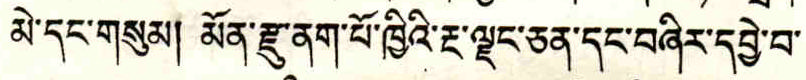

In [47]:
image = Image.open(train_dataset.root_dir + train_df['batch_name'][0] + '/' + train_df['file_name'][0]).convert("RGB")
image

In [48]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

མེ་དང་གསུམ། མོན་རྫུ་ནག་པོ་ཁྱིའི་རྔ་ལྗང་ཅན་དང་བཞིར་དབྱེ་བ་


Let's create corresponding dataloaders:

## Prepare data

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [49]:

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [50]:
use_existing_model = True
model_name = "test"

In [51]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if use_existing_model:
    model = VisionEncoderDecoderModel.from_pretrained(model_name)
else:
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encode, decode)

model.to(device)

assert model.config.decoder.is_decoder is True
assert model.config.decoder.add_cross_attention is True

cuda


Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [52]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 512
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.5
model.config.num_beams = 4


We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [53]:
from datasets import load_metric

cer_metric = load_metric("cer")

C:\Users\301212298\AppData\Local\pypoetry\Cache\virtualenvs\trocr-tibetan-fine-tuning-OTNbRY7o-py3.10\lib\site-packages\datasets\load.py:753: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [54]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [56]:
from transformers import AdamW
from tqdm.notebook import tqdm
import datetime

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
best_cer = 10.0
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

for epoch in range(10):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer 

   print("Validation CER:", valid_cer / len(eval_dataloader))
   if valid_cer < best_cer:
       print('Updating the best model')
       best_cer = valid_cer
       model.save_pretrained(f"best_model_{date}")
   

model.save_pretrained(f"test_{date}")

  0%|          | 0/20 [00:00<?, ?it/s]

Loss after epoch 0: 0.006828103504085447


  0%|          | 0/5 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.5, 'no_repeat_ngram_size': 3}
Removed shared tensor {'decoder.lm_head.decoder.bias', 'decoder.lm_head.decoder.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


Validation CER: 0.01590926137661252
Updating the best model
Saving the epoch weights


  0%|          | 0/20 [00:00<?, ?it/s]

Loss after epoch 1: 0.003894983274949482


  0%|          | 0/5 [00:00<?, ?it/s]

Validation CER: 0.01679815026550141
Saving the epoch weights


  0%|          | 0/20 [00:00<?, ?it/s]

Loss after epoch 2: 0.0013555221616115888


  0%|          | 0/5 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.5, 'no_repeat_ngram_size': 3}


Validation CER: 0.014947722915074063
Updating the best model
Saving the epoch weights


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.